In [2]:
import numpy as np
import pandas as pd 
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [8]:
INPUT_FOLDER = r'D:\siemens\first presentation\3d visiulization\LIDC-IDRI'
scans = os.listdir(INPUT_FOLDER)
scans.sort()

In [9]:
scans

['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010']

In [10]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

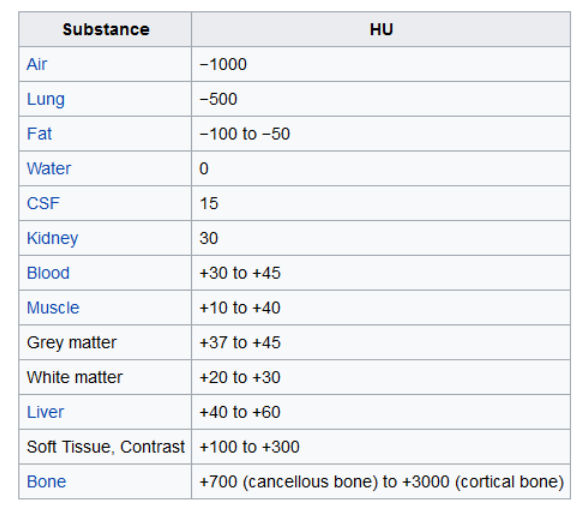

In [12]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    image[image == -2000] = 0
    
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
first_patient = load_scan(INPUT_FOLDER + r"\LIDC-IDRI-0001\01-01-2000-NA-NA-30178\3000566.000000-NA-03192")
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [22]:
def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [23]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 360, 360)


In [37]:
def plot_3d(image, threshold=-300):
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold ,allow_degenerate=True)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [38]:
def partial_plot_3d(image, threshold=-300):
    p = image.transpose(2,1,0)
    
    # verts, faces = measure.marching_cubes_classic(p, threshold)
    verts, faces,_, _ = measure.marching_cubes(p, threshold, allow_degenerate=True)
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    
    return (verts,faces)

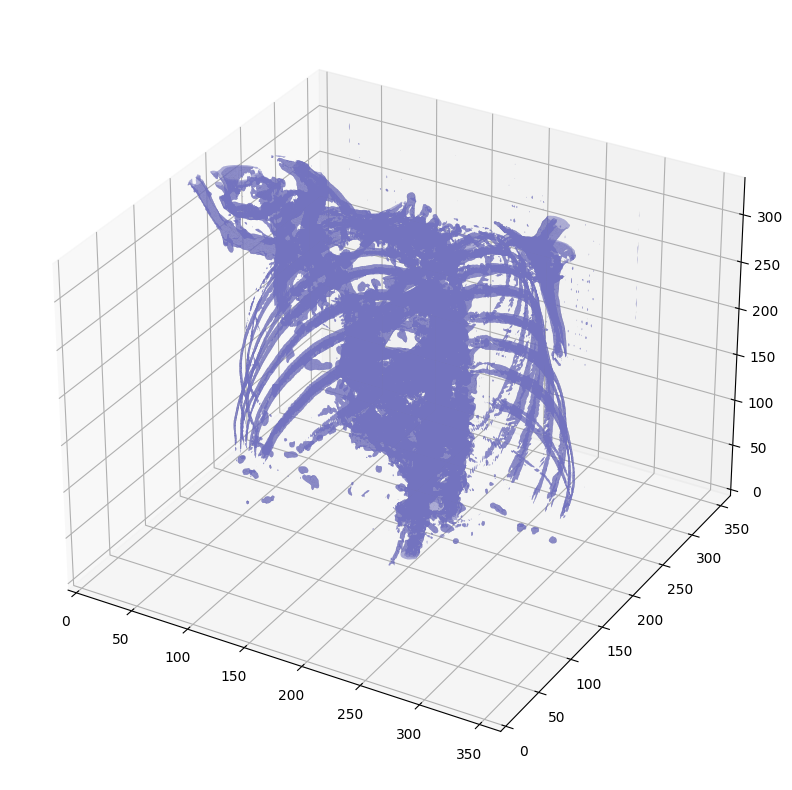

In [39]:
plot_3d(pix_resampled, 400)

In [41]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [42]:
def segment_lung_mask(image, fill_lung_structures=True):
    # 0 background 1 air 2 human parts
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
    
    binary_image[background_label == labels] = 2
    
    if fill_lung_structures:
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None:
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 
    binary_image = 1-binary_image 
    
    # Remove other air pockets 
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: 
        binary_image[labels != l_max] = 0
 
    return binary_image

In [43]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

In [44]:
mesh = partial_plot_3d(segmented_lungs, 0)

In [45]:
verts, faces = partial_plot_3d(segmented_lungs, 0)

In [46]:
verts

array([[ 54., 166., 103.],
       [ 55., 166., 102.],
       [ 55., 165., 103.],
       ...,
       [309., 168., 118.],
       [309., 169., 116.],
       [309., 169., 117.]], dtype=float32)

In [47]:
verts[faces].shape

(891780, 3, 3)

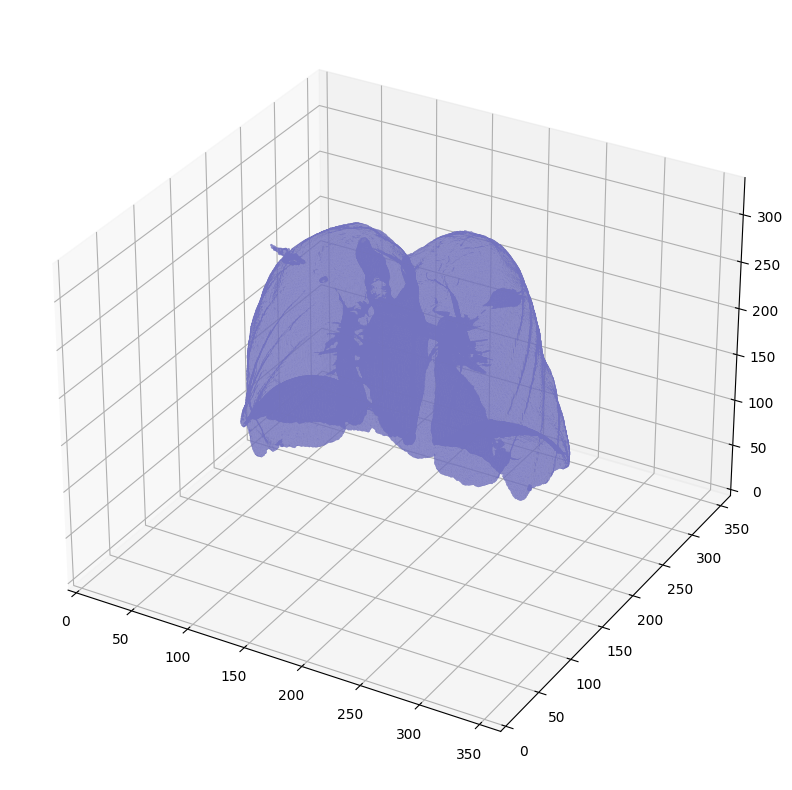

In [55]:
plot_3d(segmented_lungs_fill, 0)

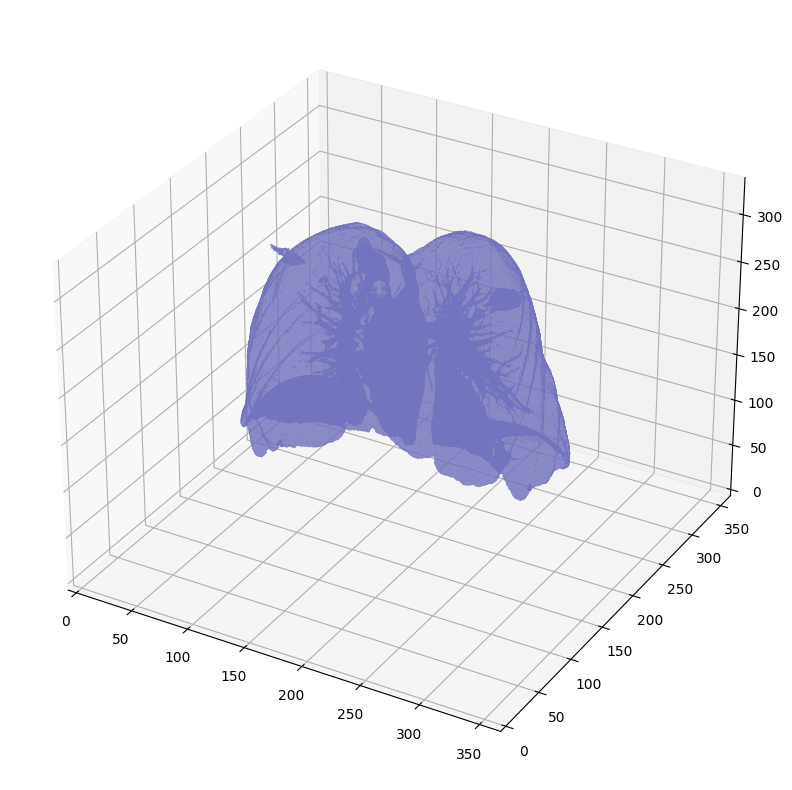

In [52]:
plot_3d(segmented_lungs, 0)

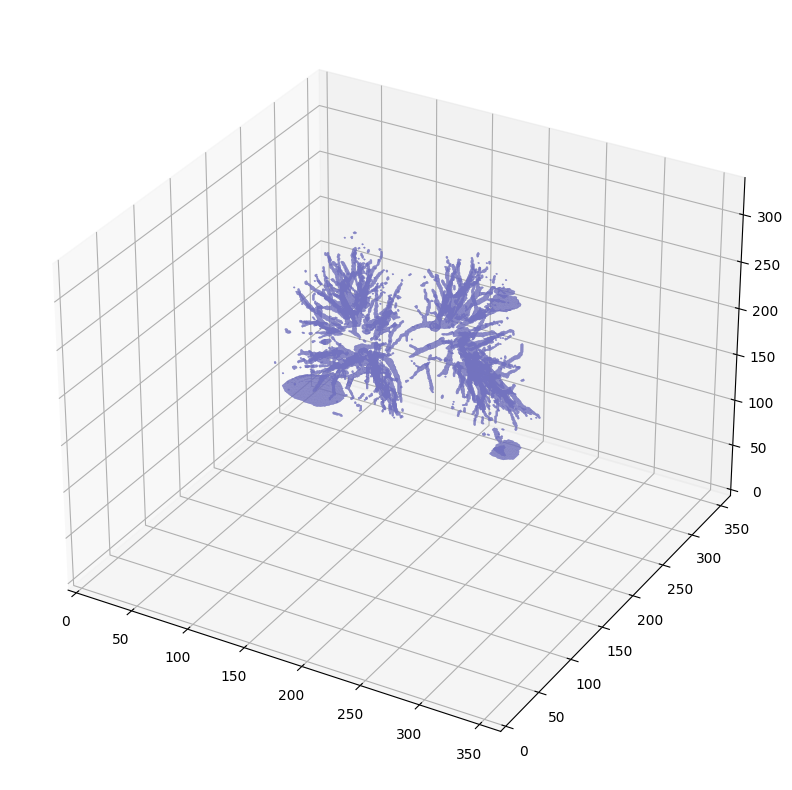

In [48]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)